## View 1

### Measurement Calculation Patterns and Magnitude Uncertainty Across Top Networks

*How is magnitude measurement calculation type (`magType`) used among the top 5 networks, and how does magnitude measurement uncertainty (`magError`) change among the top 5 networks, measurement calculations, and the number of stations that recorded the event?*

In [1]:
import pandas as pd
import altair as alt
import numpy as np

alt.data_transformers.disable_max_rows() # disable the "max rows = 5000" setting
alt.renderers.enable("mimetype") # to be able to view all charts in GitHub

earthquakes = pd.read_csv('../../../data/processed/ordinal_data.csv')

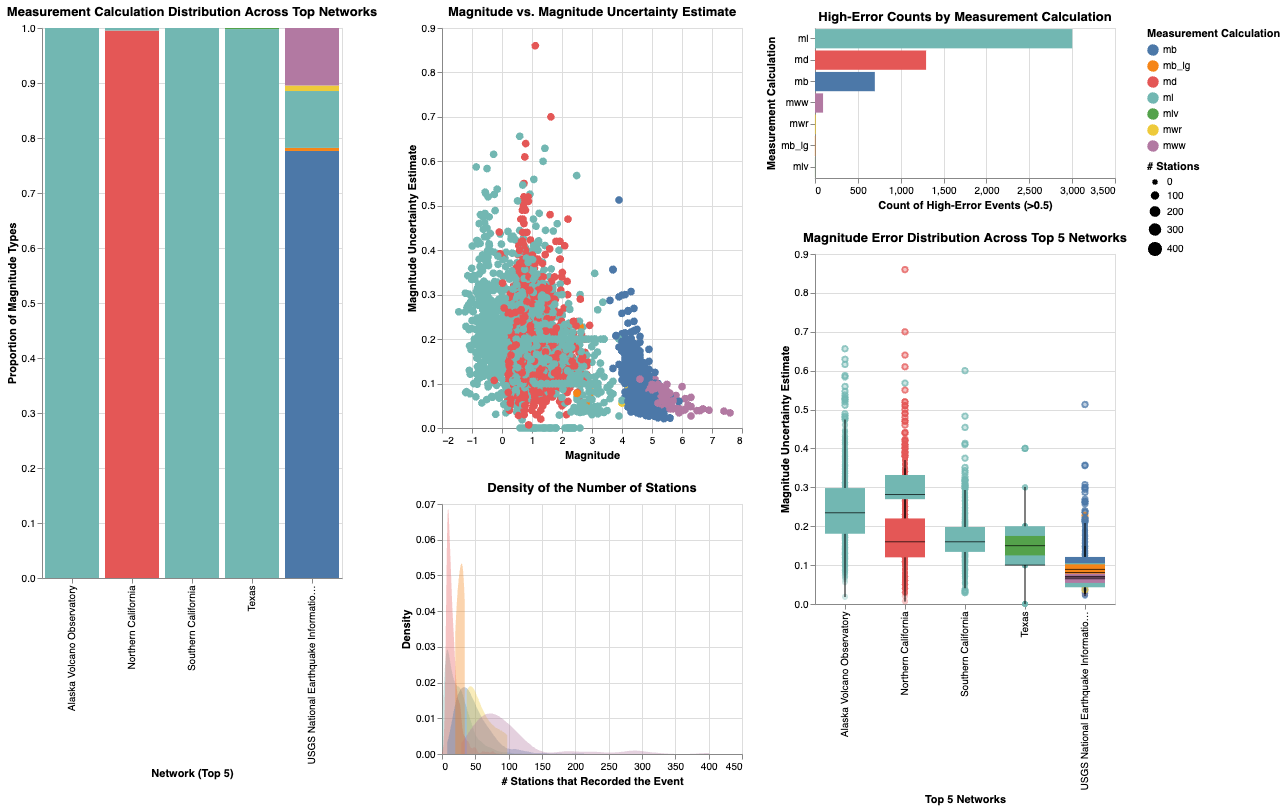

In [2]:
# ------------------
# DATA PREP
# ------------------

# filter top 5 networks
top_nets = earthquakes['net'].value_counts().nlargest(5).index
top_earthquakes = earthquakes[earthquakes['net'].isin(top_nets)].copy()

# map full network names
network_labels = {
    'av': 'Alaska Volcano Observatory',
    'ci': 'Southern California',
    'nc': 'Northern California',
    'tx': 'Texas',
    'us': 'USGS National Earthquake Information Center'
}
top_earthquakes['net_full'] = top_earthquakes['net'].map(network_labels)

# normalize counts for stacked bar
prop_df = (
    top_earthquakes.groupby(['net_full','magType'], as_index=False)
    .agg(count=('magType','count'))
)
prop_df['prop'] = prop_df.groupby('net_full')['count'].transform(lambda x: x/x.sum())

# ------------------
# INTERACTIONS
# ------------------

# interactive legend for stacked bar - direct manipulation
legend_select = alt.selection_point(fields=['magType'], bind='legend', empty='all')

# checkbox for scaling point size by # stations
bind_checkbox = alt.binding_checkbox(name='Scale point size by # Stations')
size_param = alt.param(bind=bind_checkbox, value=False)  # default unchecked

# brush for scatter
brush = alt.selection_interval(encodings=['x','y'])

# selection for bi-directional click
magtype_select = alt.selection_point(fields=['magType'])

# ------------------
# NORMALIZED STACKED BAR CHART: distribution of the proportions of magnitude measurement calculation types among the top 5 networks 
# ------------------

stacked_bar = alt.Chart(prop_df).mark_bar().encode(
    alt.X('net_full:N', title="Network (Top 5)"),
    alt.Y('prop:Q', title="Proportion of Magnitude Types"),
    alt.Color('magType:N', title='Measurement Calculation'),
    opacity = alt.condition(legend_select, alt.value(1), alt.value(0.2)),
    order = alt.Order('magType', sort='ascending'),
    tooltip = [
        alt.Tooltip('net_full:N', title='Network'),
        alt.Tooltip('magType:N', title='Measurement Calculation'),
        alt.Tooltip('count:Q', title='Count'),
        alt.Tooltip('prop:Q', title='Proportion', format=".4%")
    ]
).add_params(
    legend_select
).properties(
    width=300,
    height=550,
    title="Measurement Calculation Distribution Across Top Networks")

# ------------------
# SCATTER PLOT: magnitude vs measurement uncertainty estimate with point size toggle
# ------------------

scatter = alt.Chart(top_earthquakes).mark_point(filled=True).encode(
    alt.X('mag:Q', title='Magnitude'),
    alt.Y('magError:Q', title='Magnitude Uncertainty Estimate'),
    alt.Color('magType:N', title='Measurement Calculation'),
    size = alt.condition(size_param, alt.Size('nst:Q', title='# Stations', scale=alt.Scale(range=[30,200])), alt.value(60)),
    tooltip = ['net_full:N','mag:N','magType:N','magError:Q','depth:Q', 'nst:Q'],
    opacity = alt.condition(brush, alt.value(1.0), alt.value(0.3))
).transform_filter(
    legend_select
).transform_filter(
    magtype_select
).add_params(
    brush, size_param
).properties(
    width=300, 
    height=400, 
    title='Magnitude vs. Magnitude Uncertainty Estimate')

# ------------------
# BAR CHART, DERIVED DATA: count of high-errors for each measurement calculation type
# ------------------

# my defined high error threshold: errors > 0.5
high_error_threshold = 0.5

high_error_bar = alt.Chart(top_earthquakes).mark_bar().encode(
    alt.X('count():Q', title=f'Count of High-Error Events (>{high_error_threshold})'),
    alt.Y('magType:N', title='Measurement Calculation', sort='-x'),
    alt.Color('magType:N', title='Measurement Calculation'),
    opacity = alt.condition(magtype_select, alt.value(1.0), alt.value(0.5)),
    tooltip = [alt.Tooltip('magType:N', title='Measurement Calculation'),
               alt.Tooltip('count():Q', title='Count')]
).transform_filter(
    brush
).transform_filter(
    legend_select
).add_params(
    magtype_select
).properties(
    width=300, 
    height=150, 
    title='High-Error Counts by Measurement Calculation')

# ------------------
# BOXPLOT + JITTER PLOT: measurement uncertainty estimates distribution for top 5 networks
# ------------------

jitter = alt.Chart(top_earthquakes).mark_circle(size=40, opacity=0.35).encode(
    alt.X('net_full:N', title='Top 5 Networks'),
    alt.Y('magError:Q', title='Magnitude Uncertainty Estimate'),
    alt.Color('magType:N', title='Measurement Calculation'),
    tooltip = ['net_full:N', 'mag:N', 'magError:Q', 'magType:N', 'nst:Q', 'depth:Q']
).transform_filter(
    legend_select
).transform_filter(
    brush
).transform_filter(
    magtype_select
).add_params(
    legend_select, brush, magtype_select)

box = alt.Chart(top_earthquakes).mark_boxplot(size=40, median={'color': 'black'}).encode(
    alt.X('net_full:N', title='Top 5 Networks'),
    alt.Y('magError:Q', title='Magnitude Uncertainty Estimate'),
    alt.Color('magType:N')
).transform_filter(
    legend_select
).transform_filter(
    brush
).transform_filter(
    magtype_select
)

magerror_boxplot = (jitter + box).properties(
    width=300,
    height=350,
    title="Magnitude Error Distribution Across Top 5 Networks")

# ------------------
# DENSITY PLOT: distribution of the number of stations that recorded the event
# ------------------

nst_density = alt.Chart(top_earthquakes).transform_filter(
    legend_select
).transform_filter(
    brush
).transform_filter(
    magtype_select
).transform_density(
    'nst',
    groupby=['magType'],
    as_=['nst', 'density']
).mark_area(
    opacity=0.35
).encode(
    alt.X('nst:Q', title='# Stations that Recorded the Event'),
    alt.Y('density:Q', title='Density'),
    alt.Color('magType:N', title='Measurement Calculation'),
    tooltip = ['magType:N', 'density:Q']
).add_params(
    magtype_select
).properties(
    width=300, 
    height=250, 
    title='Density of the Number of Stations')

# ------------------
# FINAL LAYOUT
# ------------------

view1 = stacked_bar | (scatter & nst_density) | (high_error_bar & magerror_boxplot)
view1